# Goals
* We want to use MTBS as the labels to try to model MTBS severity off of rapid post-fire assessment satellite imagery
* For fires, you have to have a separate image per fire to do a proper temporal windowing for pre- and post-fire
* So the funadmental sample unit is one fire, inside which we will create a certain number of image chips
* We will use some metric to select a representative handful of fires in the Sierra Nevada region to create our 10k image chips
* Then we will create the pre- and post- fire imagery for each of those fires, and append the MTBS severity raster as the labels, 
* So we will be passing to the model a raster dataset of pre-, post-, label

In [1]:
import ee
ee.Initialize(project='pyregence-ee')

## Data Exploration and Sampling Strategy

In [2]:
# Sierras 
region = (ee.FeatureCollection("projects/pyregence-ee/assets/conus/landfire/zones")
            .filterMetadata('ZONE_NUM', 'equals', 6))

mtbs_bs = (ee.ImageCollection("USFS/GTAC/MTBS/annual_burn_severity_mosaics/v1")
.filterMetadata('system:index', 'contains', 'CONUS'))
print(mtbs_bs.size().getInfo())
# we will re-classify the severity values to 
# lump unburned and low together, 
# background and non-mapping area together, 
# and increased greenness in with .. low?
print(mtbs_bs.first().getInfo()['properties']['Severity_class_values'])
print(mtbs_bs.first().getInfo()['properties']['Severity_class_names'])

def reclass(img):
    return img.remap([0,1,2,3,4,5,6],[0,1,1,2,3,1,0])

mtbs_bs = mtbs_bs.map(reclass)


39
[0, 1, 2, 3, 4, 5, 6]
['Background', 'Unburned to Low', 'Low', 'Moderate', 'High', 'Increased Greenness', 'Non-Mapping Area']


In [3]:
mtbs_fires = ee.FeatureCollection("USFS/GTAC/MTBS/burned_area_boundaries/v1")

sierra_fires = mtbs_fires.filterBounds(region)
# print(sierra_fires.size().getInfo())

# how many intiial versus extended fire assessments
print(sierra_fires.aggregate_histogram('Asmnt_Type').getInfo())

{'Extended': 422, 'Initial': 218, 'Initial (SS)': 16}


In [4]:
from pprint import pprint
# we will only use extended assessment fires occurring in or after 2013 (HLS coverage begins in 2013)
def set_year(f):
    return f.set('year', ee.Date(f.get('Ig_Date')).get('year'))

sierra_fires = (sierra_fires
.filter(ee.Filter.eq('Asmnt_Type', 'Extended'))
.map(set_year)
.filter(ee.Filter.gte('year',2013))

)
print(sierra_fires.size().getInfo())
pprint(sierra_fires.aggregate_histogram('year').getInfo())

105
{'2013': 9,
 '2014': 10,
 '2015': 8,
 '2016': 14,
 '2017': 15,
 '2018': 11,
 '2019': 5,
 '2020': 15,
 '2021': 13,
 '2022': 5}


* Lets explore the relationship of fire severity to fire size to determine a useful sampling strategy

In [5]:
def ratio(f):
    """Set the ratio of high severity area to total fire area on a fire (ee.Feature)"""
    area = f.geometry().area()
    mtbs_year = mtbs_bs.filter(ee.Filter.calendarRange(f.get('year'), f.get('year'), 'year')).first()
    reducer = ee.Reducer.sum()
    area_img = ee.Image.pixelArea()
    hs = mtbs_year.eq(3).selfMask() # high severity binary img
    hs_area = area_img.updateMask(hs).reduceRegion(reducer, f.geometry(), 30)
    return f.set('area',area,
                 'hs_ratio', ee.Number(hs_area.get('area')).divide(area),
                 'hs_area', hs_area.get('area'))

# test it
r = ratio(sierra_fires.first())
pprint(r.getInfo()['properties'])

# map it 
sierra_fires = sierra_fires.map(ratio)

{'Asmnt_Type': 'Extended',
 'BurnBndAc': 2828,
 'BurnBndLat': '40.378',
 'BurnBndLon': '-120.749',
 'Comment': '',
 'Event_ID': 'CA4036812080220160911',
 'High_T': 320,
 'Ig_Date': 1473577200000,
 'IncGreen_T': -150,
 'Incid_Name': 'WILLARD',
 'Incid_Type': 'Wildfire',
 'Low_T': 30,
 'Map_ID': 10004874,
 'Map_Prog': 'MTBS',
 'Mod_T': 155,
 'NoData_T': -970,
 'Perim_ID': '',
 'Post_ID': '804403220170716',
 'Pre_ID': '804403220160713',
 'area': 11432976.885349168,
 'dNBR_offst': -37,
 'dNBR_stdDv': 16,
 'hs_area': 3139258.938008626,
 'hs_ratio': 0.27457931293742416,
 'irwinID': '0517B37F-F8E9-4260-ABB2-308BC2FA6A8A',
 'year': 2016}


In [6]:
import geemap
Map = geemap.Map()
Map.centerObject(r,12)
Map.addLayer(mtbs_bs.filter(ee.Filter.calendarRange(2016,2016, 'year')).first(),{'min':0,'max':3,'palette':['black','green','yellow','red']},'burn severity')
Map.addLayer(ee.Feature(r),{},'ratio fire')

Map

Map(center=[40.37639896236704, -120.74927438138413], controls=(WidgetControl(options=['position', 'transparent…

In [7]:
import pandas as pd
# Get 'area' and 'hs_ratio' values from the ee.FeatureCollection
area_values = sierra_fires.aggregate_array('area').getInfo()
area_values = [x/4046.86 for x in area_values] # convert to acres
hs_area_values = sierra_fires.aggregate_array('hs_area').getInfo()
hs_ratio_values = sierra_fires.aggregate_array('hs_ratio').getInfo()

# Create a pandas DataFrame
df = pd.DataFrame({'Area': area_values, 
                   'HS Area': hs_area_values, 
                   'HS Ratio': hs_ratio_values})


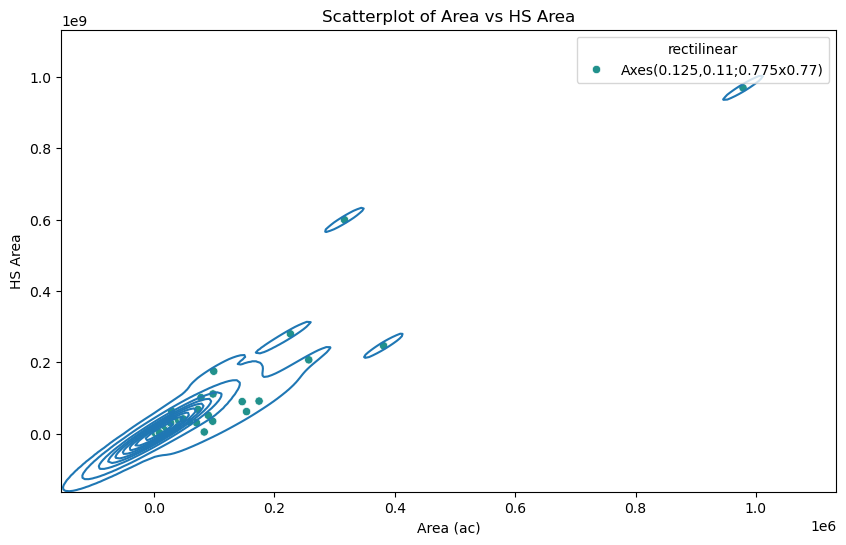

In [8]:
# Fire Area vs High Severity Area
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area', y='HS Area', hue=sns.kdeplot(df,x='Area',y='HS Area'), palette='viridis')
plt.xlabel('Area (ac)')
plt.ylabel('HS Area')
plt.title('Scatterplot of Area vs HS Area')
plt.show()

* can reasonably say that there is some kind of rough linear relationship of fire size to severity area, bigger fires have more high-severity burn area

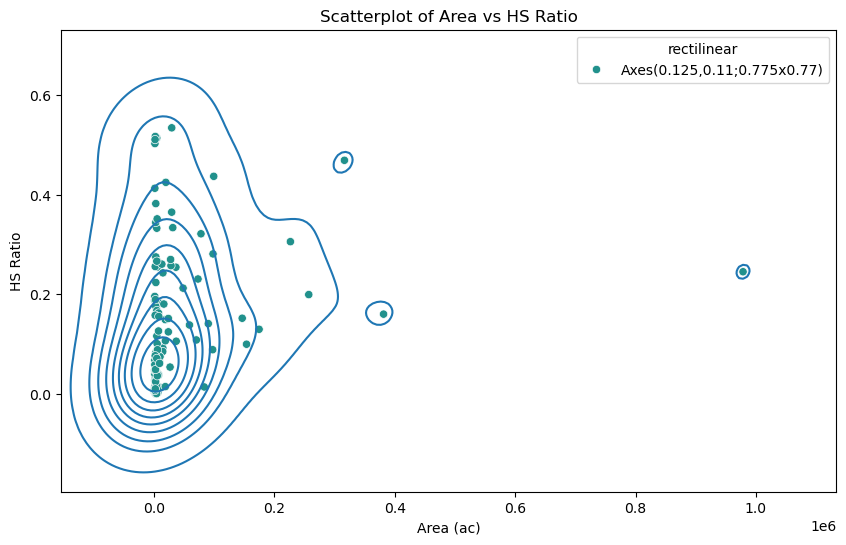

In [9]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area', y='HS Ratio', hue=sns.kdeplot(df,x='Area',y='HS Ratio'), palette='viridis')
plt.xlabel('Area (ac)')
plt.ylabel('HS Ratio')
plt.title('Scatterplot of Area vs HS Ratio')
plt.show()

* however, the % of high severity burn within a fire doesnt increase linearly with fire size

* now that we've established that, we can keep it simple with the stratification, we'll consider fire size in our train/val/test stratification

* we'll bin into small/medium/large using the fire size distribution among our dataset

In [10]:
fire_sizes = sierra_fires.aggregate_array('BurnBndAc').getInfo()
fire_sizes.sort()
print(fire_sizes)

[1006, 1057, 1063, 1064, 1102, 1120, 1137, 1168, 1181, 1184, 1204, 1270, 1313, 1316, 1455, 1477, 1672, 1700, 1733, 1805, 1840, 1996, 2121, 2141, 2150, 2289, 2315, 2317, 2448, 2487, 2633, 2706, 2718, 2793, 2828, 2829, 2977, 3003, 3034, 3155, 3508, 4065, 4264, 4346, 4362, 4390, 4415, 4545, 4968, 4980, 5221, 5556, 5743, 5990, 6018, 6163, 6488, 6955, 7016, 7224, 7229, 7713, 8053, 8495, 9011, 9090, 9685, 9717, 12765, 14252, 14416, 14534, 16100, 18485, 18576, 18640, 19408, 23564, 23611, 26437, 27331, 27938, 29150, 29191, 30967, 36151, 36626, 48066, 58747, 70171, 72894, 77858, 83297, 89960, 97307, 97831, 99070, 146369, 153687, 174424, 226583, 257084, 316556, 381441, 979795]


In [11]:
import numpy as np

# bin fires into one of 3 size classes based on the fire sizes in this distribution
percentile_value = [int(v) for v in np.percentile(fire_sizes, [25,75])]
print(f'bin edges (in acres; 25th, 75th):{percentile_value}')

small_fires = (sierra_fires.filter(ee.Filter.lt('BurnBndAc',percentile_value[0]))
.map(lambda f: f.set('size_class', 'small')))

medium_fires = (sierra_fires.filter(ee.Filter.And(ee.Filter.gte('BurnBndAc',percentile_value[0]),
                                                 ee.Filter.lt('BurnBndAc',percentile_value[1])))
.map(lambda f: f.set('size_class', 'medium')))

large_fires = (sierra_fires.filter(ee.Filter.gte('BurnBndAc',percentile_value[1]))
.map(lambda f: f.set('size_class', 'large')))

final_fires_fc = small_fires.merge(medium_fires).merge(large_fires)

print(final_fires_fc.aggregate_histogram('size_class').getInfo())


bin edges (in acres; 25th, 75th):[2315, 23611]
{'large': 27, 'medium': 52, 'small': 26}


* we will do a 70/20/5 train/val/test split
* for better model evaluation on the test set, we will withold 5% of the data as entire fires.
* the train and val dataset will consist of 75% and 20% of the rest of the 95% of fire data, chipped up and sampled at random

In [12]:
# 5% of total number of fires
# print(int(final_fires_fc.size().multiply(0.05).getInfo())) 5

# so we will randomly take 3 medium fires, and 1 small and 1 large fire respectively for our test set
test_small = (final_fires_fc
.filter(ee.Filter.eq('size_class','small'))
.randomColumn()
.limit(1,'random'))

test_medium = (final_fires_fc
.filter(ee.Filter.eq('size_class','medium'))
.randomColumn()
.limit(3,'random'))

test_large = (final_fires_fc
.filter(ee.Filter.eq('size_class','large'))
.randomColumn()
.limit(1,'random'))

test_fires = test_small.merge(test_medium).merge(test_large)

# curious what the acreage and high-severity to area ratio is for each
print(test_fires.aggregate_array('BurnBndAc').getInfo())
print(test_fires.aggregate_array('hs_ratio').getInfo())

[1840, 4264, 2828, 7229, 70171]
[0.5165802389333164, 0.5135688418886605, 0.27457931293742416, 0.1258181997250689, 0.10782655681531818]


In [13]:
# now we will remove the test fires from the final set
test_small_ids = test_small.aggregate_array('system:index')
test_medium_ids = test_medium.aggregate_array('system:index')
test_large_ids = test_large.aggregate_array('system:index')

remove_ids = test_small_ids.cat(test_medium_ids).cat(test_large_ids)
print(remove_ids.getInfo())

train_val_fires = final_fires_fc.filter(
    ee.Filter.inList('system:index', remove_ids).Not())

print(train_val_fires.size().getInfo())

['1_1_000200000000000006bc', '1_2_0001000000000000018a', '1_2_00010000000000000230', '1_2_000100000000000003bc', '2_00010000000000000ee3']
100


In [14]:
# sanity check
m = geemap.Map()
m.centerObject(region,10)
m.addLayer(train_val_fires,{},'train_val_fires')
m.addLayer(test_fires.style(**{'color':'red'}),{},'test_fires')
m

Map(center=[38.34649102173086, -119.9026752584951], controls=(WidgetControl(options=['position', 'transparent_…

In [15]:
# export
# ee.batch.Export.table.toAsset(**{
#     'collection': train_val_fires,
#     'description': 'baygeo_train_val_fires',
#     'assetId': 'projects/pyregence-ee/assets/baygeo_demo/train_val_fires'
# }).start()

# ee.batch.Export.table.toAsset(**{
#     'collection': test_fires,
#     'description': 'baygeo_test_fires',
#     'assetId': 'projects/pyregence-ee/assets/baygeo_demo/test_fires'
# }).start()


# Image Compositing

In [16]:
train_val_fires = ee.FeatureCollection("projects/pyregence-ee/assets/baygeo_demo/train_val_fires")
test_fires = ee.FeatureCollection("projects/pyregence-ee/assets/baygeo_demo/test_fires")

In [17]:
def set_dates_recent_mode(feat: ee.Feature):
    '''construct pre and post start and end dates using recent fire mode'''
    date_property = 'Ig_Date'
    feature = ee.Feature(feat)
    date = ee.Date(feature.get(date_property))
    date_readable = ee.String(date.format('YYYYMMdd')) 

    pre_start = ee.Date(date).advance(-365, 'day') # 1 year prior, same day of discovery# 1 year prior, same day of discovery
    pre_start_readable = ee.String(ee.Date(pre_start).format('YYYYMMdd')) 
    
    pre_end = ee.Date(date).advance(-275, 'day')  # 1 year prior, 90 days after discovery
    pre_end_readable = ee.String(ee.Date(pre_end).format('YYYYMMdd')) # also wasn't cast as a string before - fixed

    
    # 1st post fire composite is 1-30 days after ignition
    post1_start = ee.Date(date).advance(1, 'day')  
    post1_start_readable = ee.String(ee.Date(post1_start).format('YYYYMMdd'))

    post1_end = ee.Date(date).advance(30, 'day')   # 30 days after discovery
    post1_end_readable = ee.String(ee.Date(post1_end).format('YYYYMMdd'))

    # 2nd post fire composite is 30-60 days after ignition
    post2_start = ee.Date(date).advance(30, 'day')  
    post2_start_readable = ee.String(ee.Date(post2_start).format('YYYYMMdd'))

    post2_end = ee.Date(date).advance(60, 'day')   # 60 days after discovery
    post2_end_readable = ee.String(ee.Date(post2_end).format('YYYYMMdd'))
    
    return feature.set(
                        'Ig_Date_readable', date_readable,
                        'pre_start',pre_start,'pre_start_readable',pre_start_readable,
                        'pre_end',pre_end, 'pre_end_readable', pre_end_readable,
                        'post1_start',post1_start, 'post1_start_readable', post1_start_readable,
                        'post1_end',post1_end, 'post1_end_readable', post1_end_readable,
                        'post2_start',post2_start, 'post2_start_readable', post2_start_readable,
                        'post2_end',post2_end, 'post2_end_readable', post2_end_readable
                        )


In [18]:
# test it 
test_dates = set_dates_recent_mode(test_fires.first())
pprint(test_dates.getInfo()['properties'])

# map it 
test_fires_dates = test_fires.map(set_dates_recent_mode)
train_val_fires_dates = train_val_fires.map(set_dates_recent_mode)


{'Asmnt_Type': 'Extended',
 'BurnBndAc': 1840,
 'BurnBndLat': '35.631',
 'BurnBndLon': '-118.142',
 'Comment': '',
 'Event_ID': 'CA3564211814820140711',
 'High_T': 400,
 'Ig_Date': 1405062000000,
 'Ig_Date_readable': '20140711',
 'IncGreen_T': -150,
 'Incid_Name': 'NICOLLS',
 'Incid_Type': 'Wildfire',
 'Low_T': 70,
 'Map_ID': 22960,
 'Map_Prog': 'MTBS',
 'Mod_T': 213,
 'NoData_T': -970,
 'Perim_ID': '',
 'Post_ID': '804103520150620',
 'Pre_ID': '804103520130614',
 'area': 7449491.483453475,
 'dNBR_offst': 51,
 'dNBR_stdDv': -9999,
 'hs_area': 3848260.0904541016,
 'hs_ratio': 0.5165802389333164,
 'irwinID': '2CCDA2BF-52B2-4616-9714-A9F85198D7E3',
 'post1_end': {'type': 'Date', 'value': 1407654000000},
 'post1_end_readable': '20140810',
 'post1_start': {'type': 'Date', 'value': 1405148400000},
 'post1_start_readable': '20140712',
 'post2_end': {'type': 'Date', 'value': 1410246000000},
 'post2_end_readable': '20140909',
 'post2_start': {'type': 'Date', 'value': 1407654000000},
 'post2_sta

* now for the image chipping, it is likely more efficient (and easier for us to QA) if we make a new imageCollection, one image per fire, containing pre-, post-, and label 3-band image, 
* along with any nice metadata we can set on the image to allow us to say anything about the fire that an image chip was derived from
* the imageCollection (and maybe FC we created it from?) is the end result of this notebook

In [48]:
def composite_pre_post(feat):
    """Construct Pre and Post imagery from Harmonized Landsat Sentinel L30 (Landsat only)
            for a given fire feature"""
    pre_start = feat.get('pre_start')
    pre_end = feat.get('pre_end')
    post1_start = feat.get('post1_start')
    post1_end = feat.get('post1_end')
    post2_start = feat.get('post2_start')
    post2_end = feat.get('post2_end')
    
    region = feat.geometry()
  
    def qa(img):
        """mask clouds, shadows, snow"""
        qa_band = img.select("Fmask")
        qa_flag = int('11111',2) # 0-4 bits are cirrus, cloud, adjacent to cloud shadow, cloud shadow, snow&ice
        mask = qa_band.bitwiseAnd(qa_flag).eq(0)
        
        return img.updateMask(mask)

    hlsl30 = (ee.ImageCollection("NASA/HLS/HLSL30/v002")
    .filterBounds(region)
    .map(qa) 
     .select(['B2','B3','B4','B5','B6','B7'],
            ['blue','green','red','nir','swir1','swir2']))
    
    pre_coll = hlsl30.filterDate(pre_start, pre_end)
    post1_coll = hlsl30.filterDate(post1_start, post1_end)
    post2_coll = hlsl30.filterDate(post2_start, post2_end)

    pre_comp = (pre_coll.median().regexpRename('^[^_]*_', '') #remove all up to and including first underscore
    # .regexpRename('^(.*)$', 'pre_$1')) # adds pre_ to all bands
    )
    post1_comp = (post1_coll.median().regexpRename('^[^_]*_', '')
    # .regexpRename('^(.*)$', 'pre_$1')) # adds pre_ to all bands
    )
    post2_comp = (post2_coll.median().regexpRename('^[^_]*_', '')
    # .regexpRename('^(.*)$', 'pre_$1')) # adds pre_ to all bands
    )
    return ee.Image(ee.ImageCollection.fromImages([pre_comp, post1_comp, post2_comp])
                    .toBands()
                    .set('system:time_start', ee.Date(pre_start).millis(),
                         'system:time_end', ee.Date(post2_end).millis())
                         .copyProperties(feat))

def get_mtbs_label(feat):
    """Get the MTBS burn severity label for a given fire feature"""
    year = feat.get('year')
    severity_img = mtbs_bs.filter(ee.Filter.calendarRange(year, year, 'year')).first()
    label_img = (severity_img.eq(3) # label img is binary: high-severity(1), non-high severity (0)
        .updateMask(ee.Image().paint(feat.geometry(),1))
        .rename('label'))
    return ee.Image(label_img).copyProperties(feat)

In [49]:
# test it
test_composite = composite_pre_post(train_val_fires_dates.first())
print(test_composite.bandNames().getInfo())
# pprint(test_composite.getInfo()['properties'])

test_label = get_mtbs_label(test_fires_dates.first())
# pprint(test_label.getInfo()['properties'])

# map it
train_val_composites = train_val_fires_dates.map(composite_pre_post)
train_val_labels = train_val_fires_dates.map(get_mtbs_label)

print(train_val_composites.size().getInfo())
print(train_val_labels.size().getInfo())

test_composites = test_fires_dates.map(composite_pre_post)
test_labels = test_fires_dates.map(get_mtbs_label)

print(test_composites.size().getInfo())
print(test_labels.size().getInfo())


['0_blue', '0_green', '0_red', '0_nir', '0_swir1', '0_swir2', '1_blue', '1_green', '1_red', '1_nir', '1_swir1', '1_swir2', '2_blue', '2_green', '2_red', '2_nir', '2_swir1', '2_swir2']
100
100
5
5


In [21]:
# # sanity check
# m = geemap.Map()
# m.centerObject(train_val_fires_dates.limit(1,'BurnBndAc',False).first(),10)
# m.addLayer(ee.ImageCollection(train_val_composites).limit(1,'BurnBndAc',False).first().select([2,1,0]),{'min':0,'max':0.3},'train_val_composite')
# m.addLayer(ee.ImageCollection(train_val_labels).limit(1,'BurnBndAc',False).first(),{'min':0,'max':1,'palette':['red']},'train_val_label')
# m.addLayer(train_val_fires_dates.limit(1,'BurnBndAc',False).first(),{},'train_val_fire')
# m


In [22]:
# m = geemap.Map()
# m.centerObject(train_val_fires_dates.limit(5,'BurnBndAc',False),10)
# m.addLayer(ee.ImageCollection(train_val_composites).limit(5,'BurnBndAc',False).select([2,1,0]),{'min':0,'max':0.3},'train_val_composite')
# m.addLayer(ee.ImageCollection(train_val_labels).limit(5,'BurnBndAc',False),{'min':0,'max':1,'palette':['grey','red']},'train_val_label')
# m.addLayer(train_val_fires_dates.limit(5,'BurnBndAc',False),{},'train_val_fire')
# m

In [32]:
m = geemap.Map()
m.centerObject(test_fires_dates.limit(1,'BurnBndAc',False).first(),10)
m.addLayer(ee.ImageCollection(test_composites).limit(1,'BurnBndAc',False).first().select([2,1,0]),{'min':0,'max':0.3},'test_composite_pre')
m.addLayer(ee.ImageCollection(test_composites).limit(1,'BurnBndAc',False).first().select([8,7,6]),{'min':0,'max':0.3},'test_composite_post1')
m.addLayer(ee.ImageCollection(test_composites).limit(1,'BurnBndAc',False).first().select([14,13,12]),{'min':0,'max':0.3},'test_composite_post2')

m.addLayer(ee.ImageCollection(test_labels).limit(1,'BurnBndAc',False).first(),{'min':0,'max':1,'palette':['grey','red']},'train_val_label')
m.addLayer(test_fires_dates.limit(1,'BurnBndAc',False).first(),{},'test_fire')
m

Map(center=[38.71812748788715, -119.73064845618894], controls=(WidgetControl(options=['position', 'transparent…

In [37]:
test_composites_export = test_composites.toList(test_composites.size())

for i in list(range(test_composites_export.size().getInfo())):
    image = ee.Image(test_composites_export.get(i))
    ee.batch.Export.image.toAsset(**{
    'image': image,
    'description': f'baygeo_test_composites_{str(i)}',
    'assetId': f'projects/pyregence-ee/assets/baygeo_demo/test_composites/composite_{str(i)}',
    'region': region.geometry(),
    'scale': 30,
    'maxPixels': 1e13
}).start()